## **Estimación de la calidad del aire**

En el siguiente notebook, la predicción de la calidad del aire utilizando diferentes métricas meteorológicas y aplicando RNN.

Dataset disponible en: https://www.kaggle.com/competitions/air-quality-prediction/data

### **1. Importación de los datos**

In [54]:
# importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# herramientas
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# escalamiento y normalizacion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
# imputers
from sklearn.impute import SimpleImputer
# metricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
# mejoras
from sklearn.model_selection import GridSearchCV
# deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError, R2Score
from prophet import Prophet

c:\Users\Admin\miniconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# datos
df = pd.read_csv('train.csv')
df.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'AQI'], dtype='object')

In [3]:
# datos de test
df_test = pd.read_csv('test.csv')
df_test.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'AQI'], dtype='object')

### **2. Exploración y limpieza de los datos**

En esta sección se realiza una exploración de los datos. Se busca identificar los tipos de datos presentes y también detectar la presencia de valores nulos, con el objetivo de elegir una técnica de imputación adecuada en caso de ser necesaria.

In [4]:
# dataset
df.head(5)

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138


Los datos del dataset con temperatura del punto de rocio, temperatura, presion, direccion del viento y la calidad del aire calculada.

In [5]:
# datos
df.shape

(41757, 9)

El dataset cuenta con 41.757 filas y 9 columnas. 

In [6]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB


Se observa que el dataset contiene principalmente datos numericos, a excepcion de la direccion del viento que es del tipo object.

In [7]:
# estadisticas
print("Estadistica descriptiva del dataset")
df.describe()

Estadistica descriptiva del dataset


,No,DEWP,TEMP,PRES,Iws,Is,Ir,AQI
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,20879.000000,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866,98.613215
std,12054.351932,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165,92.050387
min,1.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,10440.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,29.000000
50%,20879.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,72.000000
75%,31318.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,137.000000
max,41757.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000,994.000000


In [8]:
# tipos de datos
df.dtypes

No        int64
DEWP      int64
TEMP    float64
PRES    float64
cbwd     object
Iws     float64
Is        int64
Ir        int64
AQI       int64
dtype: object

Se verifica los datos unicos de la columna tipo object.

In [9]:
# unicos
df['cbwd'].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

A continuación se analizan los datos faltantes en el dataset y se buscan métodos para rellenarlos en caso de ser necesario.

In [10]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
No,41757,0,0.0
DEWP,41757,0,0.0
TEMP,41757,0,0.0
PRES,41757,0,0.0
cbwd,41757,0,0.0
Iws,41757,0,0.0
Is,41757,0,0.0
Ir,41757,0,0.0
AQI,41757,0,0.0


El dataset no contiene datos faltantes.

Se procede a visualizar la distribución de los datos.

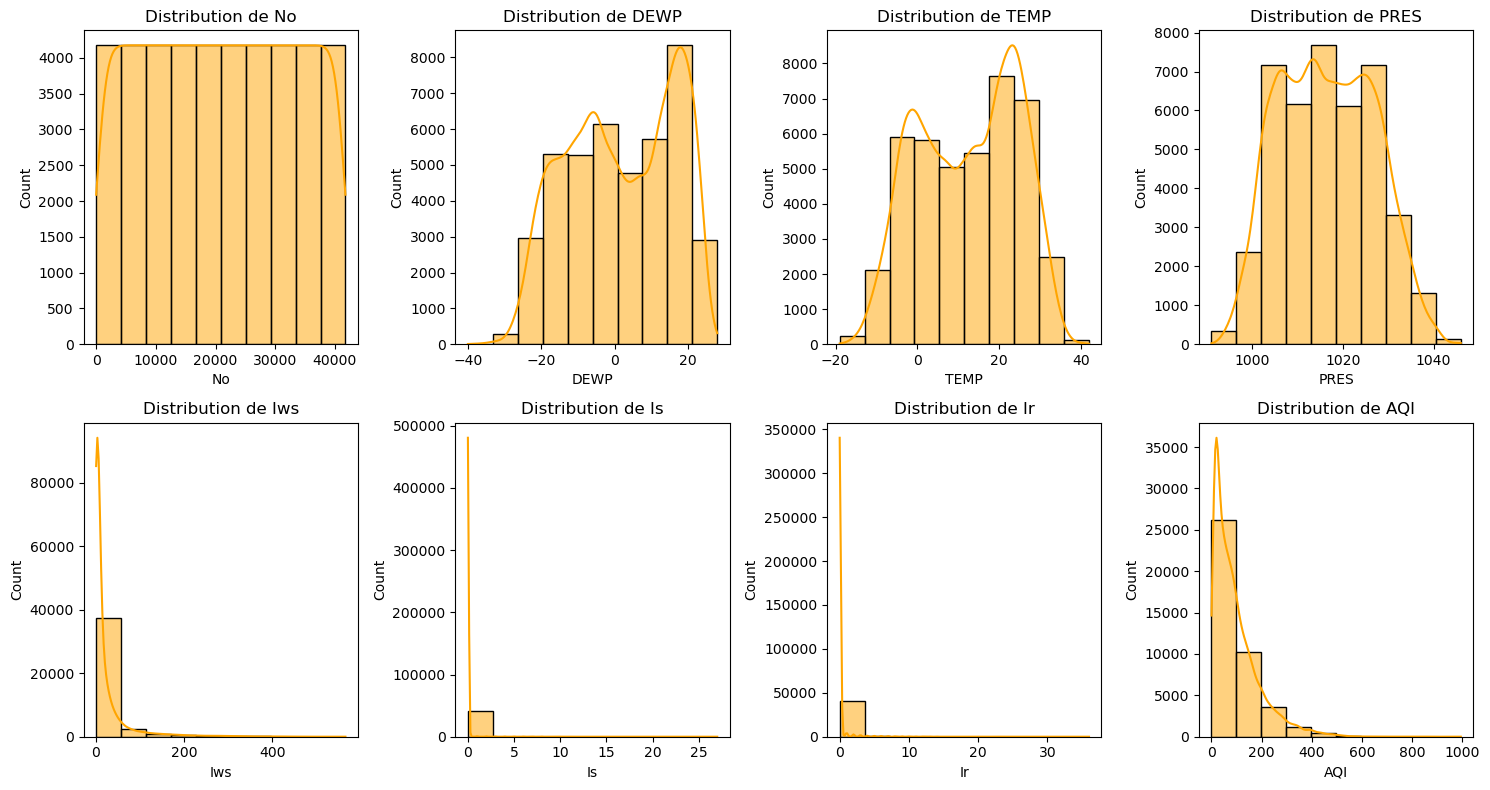

In [11]:
# numericas
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# numero de columnas y filas
cols = 4
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# distribucion de los datos
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.histplot(df[col], kde=True, color="orange", bins=10)  
    plt.title(f"Distribution de {col}")
    plt.tight_layout()

plt.show()

Tambien se procede a visualizar los boxplots para las variables numericas.

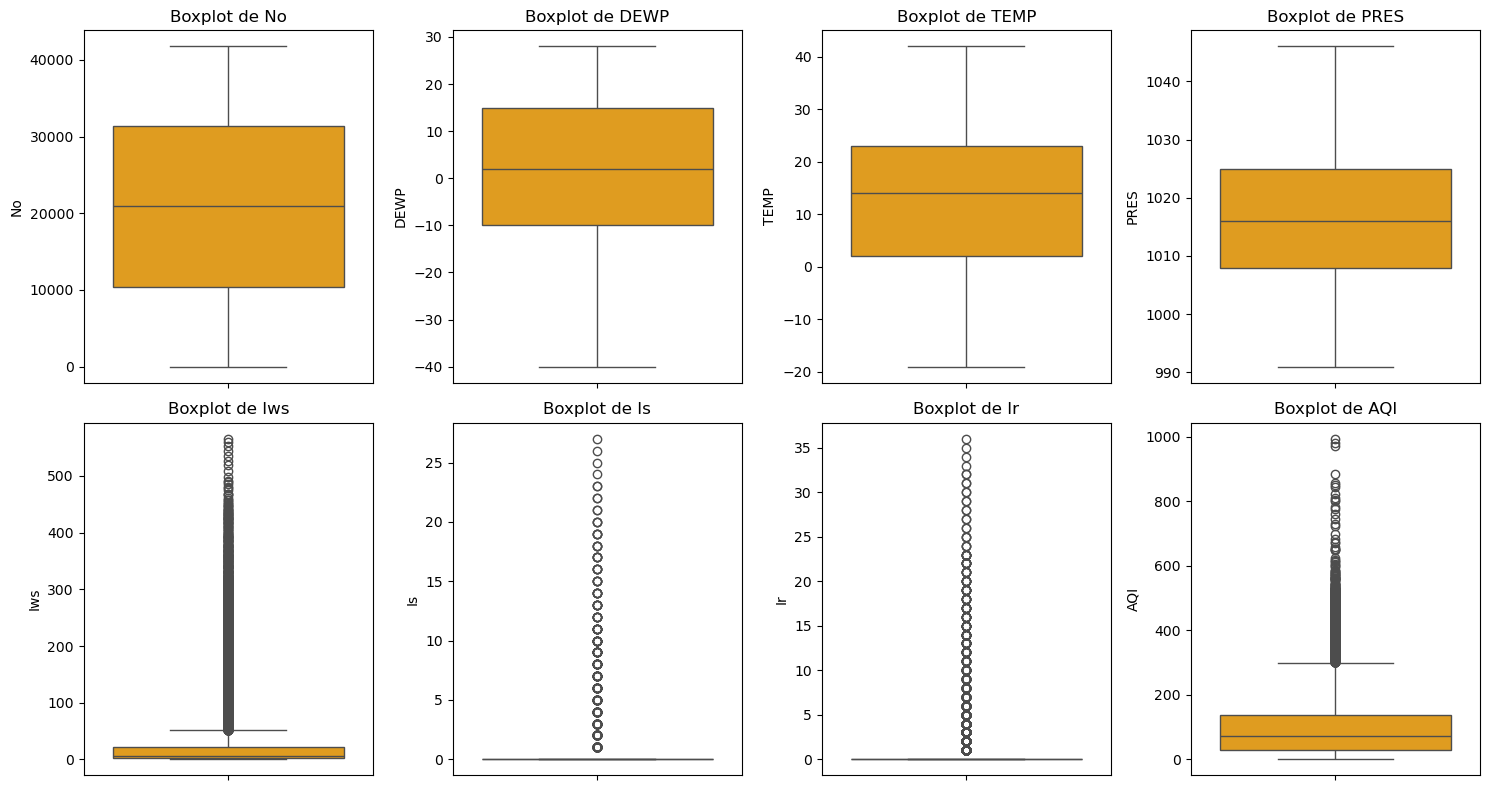

In [12]:
# numericas
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# numero de columnas y filas
cols = 4
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()

plt.show()

Se observa que hay outliers en algunas columnas.

In [13]:
# unicos
df['Iws'].describe()

count    41757.000000
mean        23.866747
std         49.617495
min          0.450000
25%          1.790000
50%          5.370000
75%         21.910000
max        565.490000
Name: Iws, dtype: float64

Iws representa una variable relacionada a la velocidad del viento acumulada diariamente. 

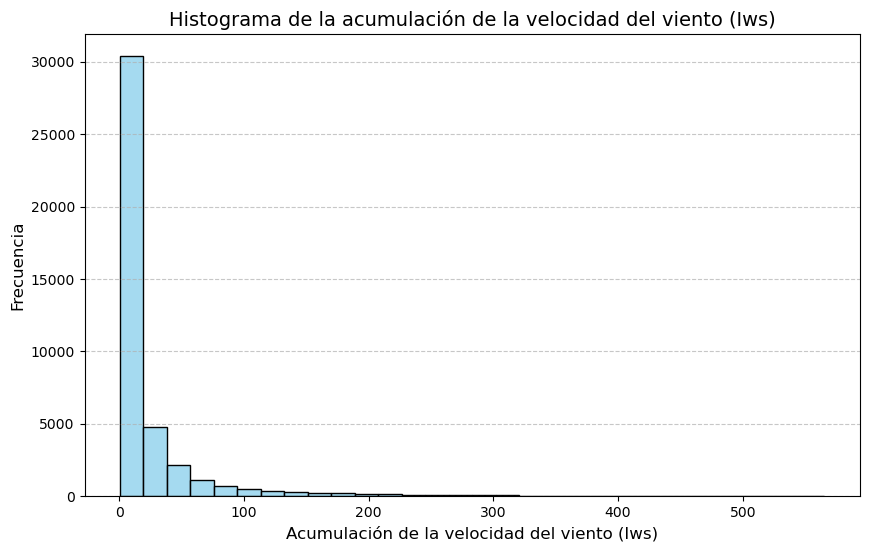

In [14]:
# histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['Iws'], bins=30, kde=False, color='skyblue')
plt.title('Histograma de la acumulación de la velocidad del viento (Iws)', fontsize=14)
plt.xlabel('Acumulación de la velocidad del viento (Iws)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Se observa que, los valores menores a 50 son mas frecuentes, lo que tiene sentido ya que se trata de valores de velocidad del viento. Aquellos valores superiores a 50, seria necesario saber en donde se obtuvieron estas mediciones, ya que pueden estar asociadas a una tormenta en particular o si se trata de outliers.

In [15]:
# filtrar
df[df['Iws'] > 90].describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,AQI
count,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000
mean,17984.435888,-13.436615,4.818743,1023.409735,179.389455,0.100981,0.185616,26.897203
std,12389.103049,10.555625,10.211687,9.718782,83.727880,1.340601,1.952949,35.936616
min,34.000000,-40.000000,-19.000000,995.000000,90.290000,0.000000,0.000000,0.000000
25%,7888.000000,-21.000000,-3.000000,1016.000000,114.890000,0.000000,0.000000,11.000000
50%,15754.000000,-16.000000,3.000000,1024.000000,152.890000,0.000000,0.000000,15.000000
75%,26821.000000,-7.000000,12.000000,1031.000000,219.930000,0.000000,0.000000,24.000000
max,41757.000000,23.000000,35.000000,1046.000000,565.490000,23.000000,32.000000,348.000000


Se observa que hay maximos de 565, lo que ya es un valor muy alto para velocidad del viento acumulada.

In [16]:
# filtrar
df[df['Iws'] > 400]

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
2699,2700,-8,12.0,1013.0,NW,410.84,0,0,16
2700,2701,-7,11.0,1014.0,NW,417.99,0,0,15
2701,2702,-7,11.0,1014.0,NW,426.04,0,0,38
2702,2703,-7,10.0,1013.0,NW,431.85,0,0,15
2703,2704,-7,10.0,1013.0,NW,434.98,0,0,18
...,...,...,...,...,...,...,...,...,...
41507,41508,-18,2.0,1025.0,NW,416.15,0,0,20
41508,41509,-18,2.0,1025.0,NW,425.09,0,0,15
41509,41510,-17,2.0,1024.0,NW,433.14,0,0,13
41510,41511,-17,2.0,1024.0,NW,437.16,0,0,14


In [17]:
# umbrales
Q1 = df['Iws'].quantile(0.25) 
Q3 = df['Iws'].quantile(0.75)  
IQR = Q3 - Q1  

# limites
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

# identificar outliers
outliers = df[(df['Iws'] < umbral_inferior) | (df['Iws'] > umbral_superior)]
print(f"Número de outliers detectados: {len(outliers)}")

Número de outliers detectados: 4893


La cantidad de outliers detectados en la variable Iws es mucha, sin embargo, se opta por mantenerlos considerando que luego los datos seran escalados a una escala comun y se verificara el impacto que tendra en el modelo.

In [18]:
# unicos
df['Ir'].describe()

count    41757.000000
mean         0.194866
std          1.418165
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.000000
Name: Ir, dtype: float64

Ir se trata de la cantidad de horas diarias de lluvia que se tuvieron, evidentemente, al ser asi, la cantidad de horas de lluvia no puede superar las 24 horas.

In [19]:
# filtrar
df[df['Ir'] > 24]

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
5862,5863,13,14.0,1015.0,NE,0.89,0,25,8
5863,5864,13,14.0,1015.0,NE,2.68,0,26,6
5864,5865,12,14.0,1015.0,NE,4.47,0,27,31
5865,5866,12,14.0,1015.0,NE,7.60,0,28,26
5866,5867,12,14.0,1015.0,NE,9.39,0,29,20
5867,5868,12,14.0,1014.0,cv,0.89,0,30,19
5868,5869,12,14.0,1014.0,cv,1.34,0,31,16
5869,5870,12,13.0,1014.0,NW,1.79,0,32,17
5870,5871,12,13.0,1014.0,NE,1.79,0,33,14
5871,5872,12,13.0,1014.0,NE,3.58,0,34,12


Los valores que superen las 24 horas, seran reemplazados por 24 horas ya que se asume que llovio durante todo el dia. 

In [20]:
# reemplazar
df['Ir'] = df['Ir'].apply(lambda x: 24 if x > 24 else x)

In [21]:
# filtrar
df[df['Ir'] > 24]

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI


In [22]:
# filtrar
df['Is'].describe()

count    41757.000000
mean         0.055344
std          0.778875
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         27.000000
Name: Is, dtype: float64

Is es una variable que describe la cantidad de horas de lluvia de nieve que se tuvo, asi que tampoco deberia de superar las 24 horas. 

In [23]:
# filtrar
df[df['Is'] > 24]

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
43,44,-11,-9.0,1022.0,cv,1.78,25,0,53
44,45,-10,-9.0,1022.0,NW,4.02,26,0,71
45,46,-11,-10.0,1023.0,NW,7.15,27,0,72


In [24]:
# reemplazar
df['Is'] = df['Is'].apply(lambda x: 24 if x > 24 else x)

In [25]:
# filtrar
df[df['Is'] > 24]

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI


In [26]:
# duplicados
df.duplicated().sum()

np.int64(0)

El dataset no contiene datos duplicados.

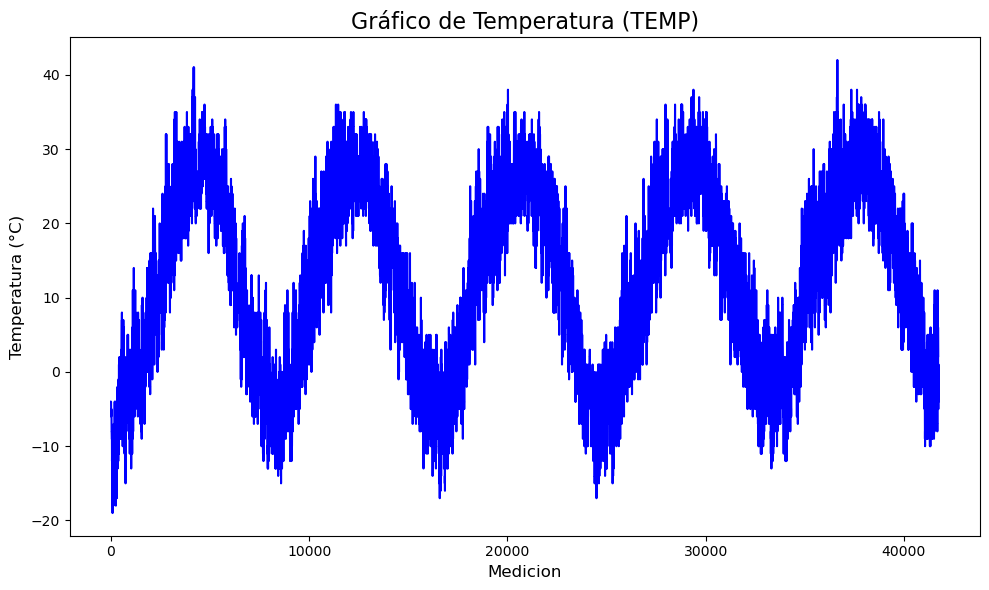

In [27]:
# gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='TEMP', color='blue')

# grafico
plt.title('Gráfico de Temperatura (TEMP)', fontsize=16)
plt.xlabel('Medicion', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.tight_layout()
plt.show()

En este grafico de temperatura se puede observar claramente la variacion diaria de la temperatura en un ciclo completo. Asi, se trata de una variable periodica al igual que las que se observan a continuaion (temperatura del punto de rocio y presion)

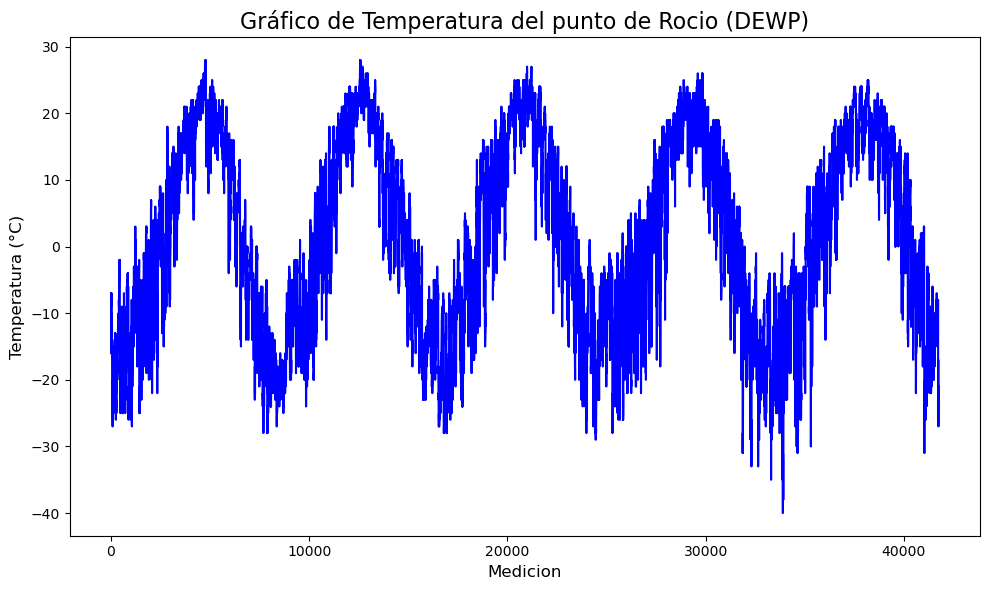

In [28]:
# gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='DEWP', color='blue')

# grafico
plt.title('Gráfico de Temperatura del punto de Rocio (DEWP)', fontsize=16)
plt.xlabel('Medicion', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.tight_layout()
plt.show()

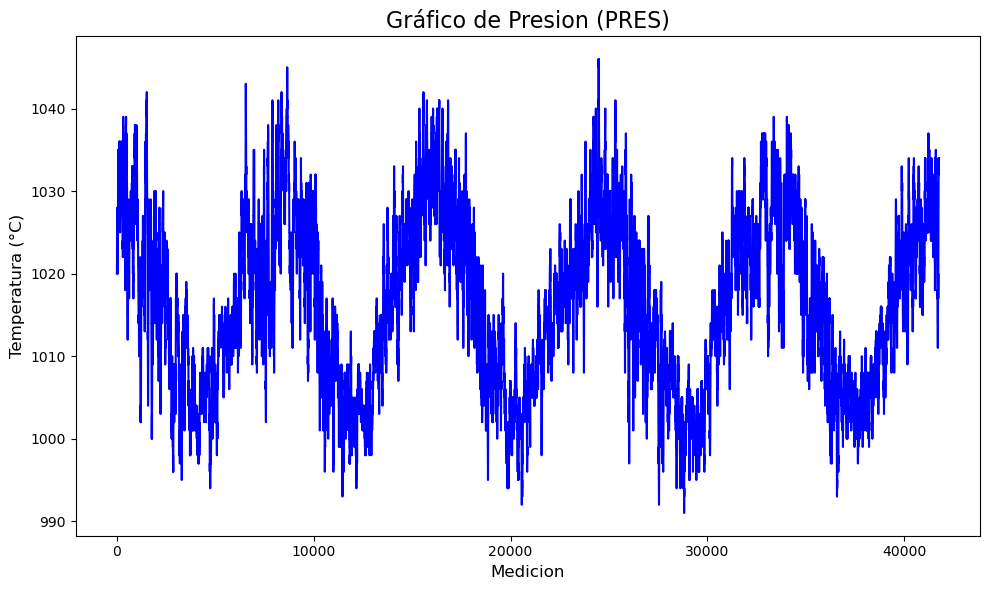

In [29]:
# gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='PRES', color='blue')

# grafico
plt.title('Gráfico de Presion (PRES)', fontsize=16)
plt.xlabel('Medicion', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.tight_layout()
plt.show()

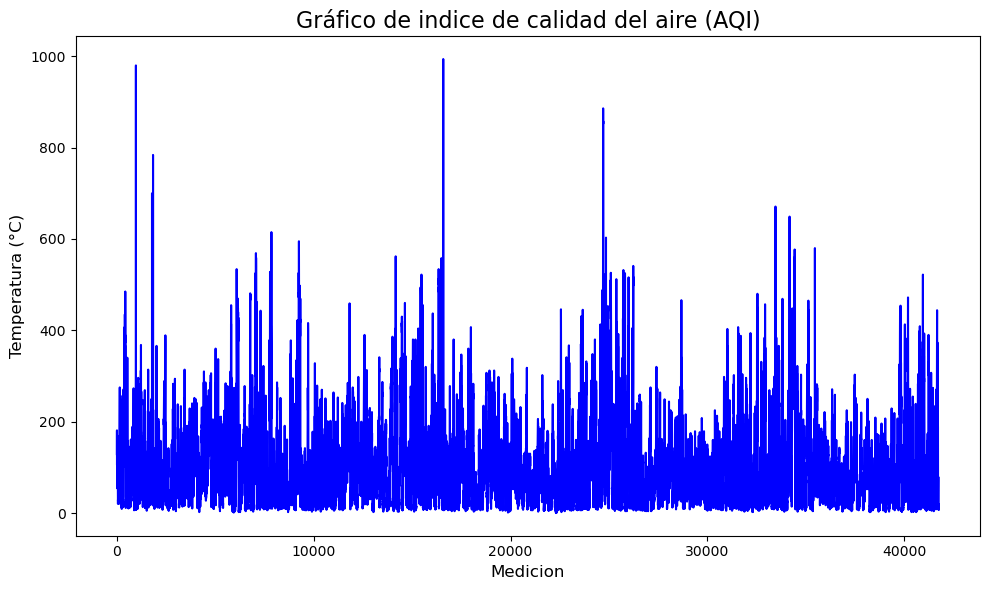

In [30]:
# gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='AQI', color='blue')

# grafico
plt.title('Gráfico de indice de calidad del aire (AQI)', fontsize=16)
plt.xlabel('Medicion', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.tight_layout()
plt.show()

En este grafico de indice de calidad del aire se observa claramente que esta variable contiene datos fuera de rango, ya que toma valores muy elevados incluso superando los 600, a continuacion se filtran dichos valores.

In [31]:
# filtrar
df[df['AQI'] > 600]

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
966,967,-14,-7.0,1029.0,cv,0.89,0,0,980
1784,1785,2,6.0,1000.0,NW,4.92,0,0,700
1836,1837,-8,11.0,1013.0,NW,11.18,0,0,784
1837,1838,-10,12.0,1013.0,NW,18.33,0,0,761
7847,7848,-6,-2.0,1012.0,cv,3.56,0,0,607
7848,7849,-6,-2.0,1013.0,cv,4.45,0,0,611
7849,7850,-7,-4.0,1013.0,cv,5.34,0,0,615
16578,16579,-24,-12.0,1032.0,NW,4.92,0,0,994
16579,16580,-24,-12.0,1032.0,NW,8.05,0,0,972
24696,24697,-7,-1.0,1021.0,SE,7.16,0,0,802


Como los datos seran procesados utilizando modelos y los outliers pueden contener informacion valiosa, se opta por mantenerlo.

### **3. Preprocesamiento y modelado de los datos**

El objetivo es aplicar un modelo RNN a los datos utilizando LSTM para predecir valores futuros en una serie temporal.

Se realiza el preprocesamiento de los datos para luego ser utilizados en modelos.

In [32]:
#df
df.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'AQI'], dtype='object')

In [33]:
# df
df.head(5)

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138


Se eligen como variable target a AQI y las demas columnas seran utlilizadas como predictoras.

In [34]:
# variables categoricas y target
x = df.drop(columns=['AQI'])  
y = df[['AQI']]

In [35]:
# extraer columnas
numerical_features = x.select_dtypes(include=['int', 'float']).columns
categorical_features =x.select_dtypes(include=['object']).columns

# verificar
print("Features numericas: ", numerical_features)
print("Features categoricas: ", categorical_features)

Features numericas:  Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir'], dtype='object')
Features categoricas:  Index(['cbwd'], dtype='object')


In [36]:
# transformadores para cada subconjunto de columnas
# numerico
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorico
categoric_transformer =  Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

In [37]:
# crear columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),  
        ('cat', categoric_transformer, categorical_features)  
    ]
)

In [38]:
# preprocesado a x
x_processed = preprocessor.fit_transform(x)

Dividir los datos en un conjunto de entrenamiento y prueba.

In [39]:
# split del dataset
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.3, random_state=42)

Seguidamente del preprocesamiento se crea el modelo RNN

In [40]:
# Reformatear los datos para LSTM: agregar una dimensión para los timesteps
x_train_lstm = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_lstm = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [41]:
# Crear el modelo LSTM con más capas
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])),  # Aumentamos las unidades y añadimos más capas
    LSTM(64, activation='tanh', return_sequences=False),  # Segunda capa LSTM
    Dropout(0.2),  # Dropout para evitar sobreajuste
    Dense(32, activation='relu'),  # Capa densa con ReLU
    Dense(1, activation='linear')  # Predicción continua
])

c:\Users\Admin\miniconda3\envs\deep_learning\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
# Ajustar la tasa de aprendizaje
optimizer = Adam(learning_rate=0.001)  # Probar con una tasa de aprendizaje más baja

In [43]:
# Compilar el modelo
model.compile(optimizer=optimizer, loss='mse', metrics=[R2Score()])

In [44]:
# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Configurar el EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,           # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del mejor modelo
)

In [46]:
# Entrenar el modelo con EarlyStopping
history = model.fit(
    x_train_lstm,  # Datos de entrenamiento
    y_train,       # Target de entrenamiento
    validation_data=(x_test_lstm, y_test),  # Datos de validación
    epochs=20, 
    batch_size=32, 
    verbose=1,
    callbacks=[early_stopping]  # Añadir EarlyStopping como callback
)

Epoch 1/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 10437.3740 - r2_score: -0.2405 - val_loss: 5798.8955 - val_r2_score: 0.3216
Epoch 2/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5784.8428 - r2_score: 0.3242 - val_loss: 5685.8877 - val_r2_score: 0.3348
Epoch 3/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5555.1650 - r2_score: 0.3409 - val_loss: 5595.3013 - val_r2_score: 0.3454
Epoch 4/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5382.2051 - r2_score: 0.3579 - val_loss: 5487.3608 - val_r2_score: 0.3581
Epoch 5/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5290.7734 - r2_score: 0.3665 - val_loss: 5457.2466 - val_r2_score: 0.3616
Epoch 6/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5252.2100 - r2_score: 0.3689 - val_loss: 5440.7266 - val_r2_score: 0.3635
Epoch 7/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5155.2671 - r2_score: 0.3715 - val_loss: 5409.3794 - val_r2_score: 0.3672
Epoch 8/20
914/914 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss:

In [47]:
# realizar predicciones
y_pred = model.predict(x_test_lstm)

392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [48]:
# evaluación del modelo en conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 49.27173614737936
Error cuadrático medio (MSE): 5188.589712613254
Coeficiente de determinación (R²): 0.39301323890686035


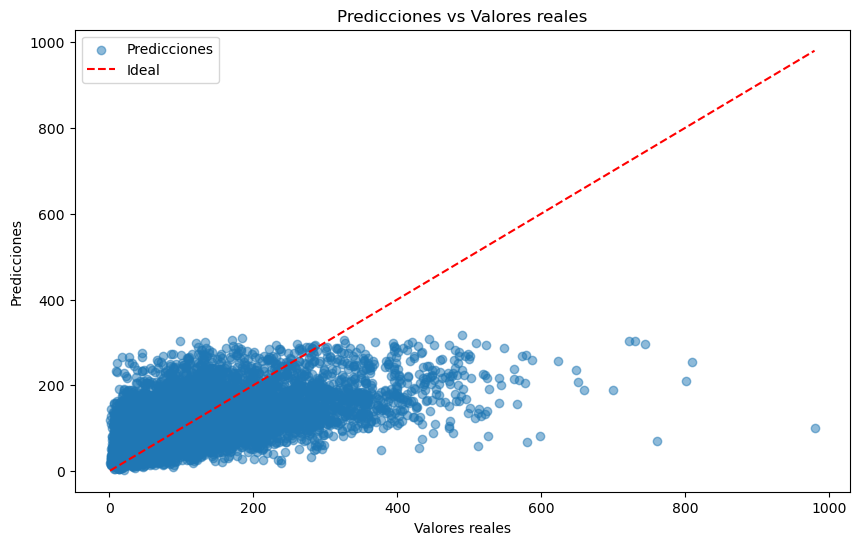

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales')
plt.legend()
plt.show()

El modelo realiza las predicciones, sin embargo, lo realiza de una forma deficiente y puede mejorarse ajustanto los parametros del modelo y aumentando el numero de epocas. En particular, con la configuracion utilizada se observa que el modelo tiende a agrupar los datos en los valores menores, lo que muy probablemente se debe a que al tener una mayor cantidad de muestras en datos de menor rango y por ello tiende a agruparlos en ese rango. 